# Случайные леса
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать ансамбль деревьев решений, известный как случайный лес, применить его к публичным данным и сравнить его эффективность с ансамблями из самых популярных библиотек.

In [1]:
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
import copy

Реализуем сам Random Forest. Идея очень простая: строим `n` деревьев, а затем берем модальное предсказание. Используйте реализацию дерева из HW3.

#### Параметры конструктора
`n_estimators` - количество используемых для предсказания деревьев.

Остальное - параметры деревьев.

#### Методы
`fit(X, y)` - строит `n_estimators` деревьев по выборке `X`.

`predict(X)` - для каждого элемента выборки `X` возвращает самый частый класс, который предсказывают для него деревья.

### Реализация Decision Tree из прошлого ДЗ

In [107]:
def gini(x):
    criterion_sum = 0
    
    overall_amount = len(x)
    
    for class_members_amount in x.value_counts():
        prob = class_members_amount / overall_amount
        
        criterion_sum += prob * (1 - prob)
        
    return criterion_sum
    
def entropy(x):
    criterion_sum = 0
    
    overall_amount = len(x)
    
    for class_members_amount in x.value_counts():
        
        prob = class_members_amount / overall_amount
        
        criterion_sum += prob * np.log2(prob)
    
    return - criterion_sum

def gain(left_right, left_y, right_y, criterion, s_total):
    
    s_node = len(left_right)
    
    impurity_left = criterion(left_y)
    impurity_right = criterion(right_y)
    
    information_gain = s_node / s_total * criterion(left_right) - len(left_y) / s_total * criterion(left_y) - len(right_y) / s_total * criterion(right_y)
    
    
    split_info = 0
    
    for unique_feature, count in zip(left_right.value_counts().index, left_right.value_counts()):
        split_info -= count / s_node * np.log2(count / s_node)
    
    gain_ratio = information_gain / split_info
    
    return gain_ratio


class DecisionTreeLeaf:
    def __init__(self, data, labels, predecessor):
        self.y = labels.value_counts().index[0]
        self.data = data
        self.labels = labels
        self.size = len(self.labels)
        self.depth = predecessor.depth + 1
        self.predecessor = predecessor
        
        self.class_probs = None
    
    def process_leaf_instance(self):
        classes_descending_order = self.labels.value_counts().index.tolist()
        classes_probabilities = self.labels.value_counts() / self.labels.shape[0]
        self.class_probs = dict(zip(classes_descending_order, classes_probabilities))
    


class DecisionTreeNode:
    def __init__(self, data, labels, predecessor=None, depth=1):
        self.split_dim = None
        self.split_value = None
        
        self.left = None
        self.right = None
        self.predecessor = predecessor
        self.depth = predecessor.depth + 1 if predecessor else depth
        
        self.data = data
        self.labels = labels
        


class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1):
        self.root = None
        self.overall_samples_amount = None
        
        self.max_depth = max_depth or float("inf")
        self.min_samples_leaf = min_samples_leaf
        self.criterion = DecisionTreeClassifier.criterias(criterion)
    
    @classmethod
    def criterias(cls, criterion):
        CRITERIA = {"gini": gini, "entropy": entropy}
        
        return CRITERIA[criterion]
        
    
    def fit(self, X, y):
        self.root = DecisionTreeNode(data=X, labels=y) # по умолчанию, так как будем делить дерево
        self.overall_samples_amount = len(y)
        self.num_of_classes = len(set(y))
        
        
        split_dim, split_value = self.get_most_informative_split(X, y)
        
        
        self.root.split_dim = split_dim
        self.root.split_value = split_value
        
        
        self.split_dataframe(self.root, X, y)
        
        self.split_node(self.root.left)
        self.split_node(self.root.right)
        
    
    def predict_proba(self, X):
        proba = []
        
        for _, x_i in X.iterrows():
            destination_node = self.walk(self.root, x_i)
            
            class_probabilities = {class_: destination_node.class_probs.get(class_, 0) for class_ in range(self.num_of_classes)}
            
            proba.append(class_probabilities)
        
        return proba
            
            
            
    def predict(self, X):
        proba = self.predict_proba(X)
        return np.array([max(p.keys(), key=lambda k: p[k]) for p in proba])
    
    def walk(self, node, x_i):
        if isinstance(node, DecisionTreeLeaf):
            return node
        if x_i[node.split_dim] < node.split_value:
            destination = self.walk(node.left, x_i)
        else:
            destination = self.walk(node.right, x_i)
        return destination
    
    def get_most_informative_split(self, data, labels):
        terminal_IG = float("-inf")
        terminal_split_value = None
        terminal_split_dim = None
        for feature in tqdm(data.columns):
        #for feature in tqdm(df.columns):
            feature_split_value = None
            feature_max_IG = float("-inf")
            
            
            for value in data[feature].unique():
            #for value in tqdm(data[feature].unique())
                left_y = labels[data[feature] < value]
                right_y = labels[data[feature] >= value]
                
                left_labels = len(set(left_y))
                right_labels = len(set(right_y))

                
                IG = gain(labels, left_y, right_y, self.criterion, self.overall_samples_amount)
                
                if IG > feature_max_IG:
                    feature_max_IG = IG
                    feature_split_value = value
            
            if feature_max_IG > terminal_IG:
                terminal_IG = feature_max_IG
                terminal_split_dim = feature
                terminal_split_value = feature_split_value
            
        return terminal_split_dim, terminal_split_value
    
    def split_dataframe(self, node, data, labels):
        left_indices = data[node.split_dim] < node.split_value
        right_indices = data[node.split_dim] >= node.split_value
        
        left_data = data[left_indices]
        right_data = data[right_indices]
        
        left_y = labels[left_indices]
        right_y = labels[right_indices]
        
        
        # условия для установления левого ответвления листом:
        if any((len(set(left_y)) == 1, node.depth + 1== self.max_depth)):
            left_child = DecisionTreeLeaf(data=left_data, labels=left_y, predecessor=node)
        else:
            left_child = DecisionTreeNode(data=left_data, labels=left_y, predecessor=node)
        
        
        if any((len(set(right_y)) == 1, node.depth + 1 == self.max_depth)):
            right_child = DecisionTreeLeaf(data=right_data, labels=right_y, predecessor=node)
        else:
            right_child = DecisionTreeNode(data=right_data, labels=right_y, predecessor=node)
            
        node.right = right_child
        node.left = left_child
    
    def split_node(self, child):
        if isinstance(child, DecisionTreeLeaf):
            child.process_leaf_instance()
        else:
            split_dim, split_value = self.get_most_informative_split(child.data, child.labels)
            
            child.split_dim = split_dim
            child.split_value = split_value
            
            self.split_dataframe(child, child.data, child.labels)
            
            self.split_node(child.left)
            self.split_node(child.right)

### Добавим унаследованный класс Решающего дерева с целью расширения функционала - теперь в каждом узле будет выбираться `max_features` для поиска лучшего сплита

In [108]:
class DecisionTreeClassifierExtended(DecisionTreeClassifier):
    def __init__(self, max_features_amount, criterion="gini", max_depth=None, min_samples_leaf=1):
        super().__init__(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        
        self.max_features_amount = max_features_amount
        
    
    def get_features_subset(self, columns):
        random_features = np.random.choice(columns, replace=False, size=self.max_features_amount)
        
        return random_features
    
    
    def fit(self, X, y):
        
        self.root = DecisionTreeNode(data=X, labels=y)
        self.overall_samples_amount = len(y)
        self.num_of_classes = len(set(y))
        
        random_features = self.get_features_subset(X.columns)

        split_dim, split_value = self.get_most_informative_split(X, y, random_features)
        
        
        self.root.split_dim = split_dim
        self.root.split_value = split_value
        
        
        self.split_dataframe(self.root, X, y)
        
        self.split_node(self.root.left)
        self.split_node(self.root.right)
    
    def get_most_informative_split(self, data, labels, features_subset):
        terminal_IG = float("-inf")
        terminal_split_value = None
        terminal_split_dim = None
        
        for feature in features_subset:
            feature_split_value = None
            feature_max_IG = float("-inf")
            
            
            for value in data[feature].unique():
                left_y = labels[data[feature] < value]
                right_y = labels[data[feature] >= value]
                
                left_labels = len(set(left_y))
                right_labels = len(set(right_y))
                                
                IG = gain(labels, left_y, right_y, self.criterion, self.overall_samples_amount)
                if IG > feature_max_IG and all((len(left_y) >= self.min_samples_leaf, len(right_y >= self.min_samples_leaf))):
                    feature_max_IG = IG
                    feature_split_value = value
            
            if feature_max_IG > terminal_IG:
                terminal_IG = feature_max_IG
                terminal_split_dim = feature
                terminal_split_value = feature_split_value

        return terminal_split_dim, terminal_split_value
    
    def split_node(self, child):
        if isinstance(child, DecisionTreeLeaf):
            child.process_leaf_instance()
        else:
            split_dim = None
            
            while split_dim is None:
                random_features = self.get_features_subset(child.data.columns)
                split_dim, split_value = self.get_most_informative_split(child.data, child.labels,
                                                                    random_features)
            
            child.split_dim = split_dim
            child.split_value = split_value
            
            self.split_dataframe(child, child.data, child.labels)

            self.split_node(child.left)
            self.split_node(child.right)


In [109]:
from sklearn.base import BaseEstimator

In [110]:
class RandomForestClassifier(BaseEstimator):
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1, max_features="auto", 
                 n_estimators=10, bootstrap_ratio=0.8):
        
        self.criterion = criterion
        self.n_estimators = n_estimators
        
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth if max_depth else 999
        self.max_features = max_features
        self.bootstrap_ratio = 0.8
    
    @classmethod
    def max_features_func(cls, strategy):
        
        strategies = {"auto": np.sqrt,
                     "sqrt": np.sqrt,
                     "log2": np.log2,
                     }
        
        return strategies[strategy]
        
    def bootstrap(self, length):
        indices = tuple(np.arange(length))
        bootstrap_size = int(length * self.bootstrap_ratio)
        bootstrap_indices = np.array([list(np.random.choice(indices, size=bootstrap_size)) for _ in range(self.n_estimators)])
        out_of_bag_indices = [list(set(indices) - set(tuple(bootstrap_i))) for bootstrap_i in bootstrap_indices]
        
        return bootstrap_indices, out_of_bag_indices
    
    def fit(self, X, y):
        bootstrap_indices, self.OOB_indices = self.bootstrap(X.shape[0])
        max_features_amount = int(self.max_features_func(self.max_features)(X.shape[1]))
        self.estimators = np.array([DecisionTreeClassifierExtended(max_depth=self.max_depth,
                                                          min_samples_leaf=self.min_samples_leaf,
                                                          criterion=self.criterion,
                                                                   max_features_amount=max_features_amount) for _ in range(self.n_estimators)])


        for estimator_idx in tqdm(range(self.n_estimators)):
            X_bootstrapped, y_bootstrapped = X.iloc[bootstrap_indices[estimator_idx]], y.iloc[bootstrap_indices[estimator_idx]]
            
            
            self.estimators[estimator_idx].fit(X_bootstrapped, y_bootstrapped)
            
            
        return self
    def get_forest_predictions(self, X):
        
        return np.array([estimator.predict(X) for estimator in self.estimators]).T
    
    
    def predict(self, X):
        
        predictions = self.get_forest_predictions(X)
        
        forest_final_predictions = np.array([np.argmax(np.bincount(preds)) for preds in predictions])
        
        return forest_final_predictions

### 
Оптимизируйте по `AUC` на кроссвалидации (размер валидационной выборки - 20%) параметры своей реализации `Random Forest`: 

максимальную глубину деревьев из [2, 3, 5, 7, 10], количество деревьев из [5, 10, 20, 30, 50, 100]. 

Постройте `ROC` кривую (и выведите `AUC` и `accuracy`) для лучшего варианта.

Подсказка: можно построить сразу 100 деревьев глубины 10, а потом убирать деревья и
глубину.

In [111]:
path_x_train = r"{}x_spam_train.csv"
path_y_train = r"{}y_spam_train.csv"
path_x_test = r"{}x_spam_test.csv"

In [112]:
X_train = pd.read_csv(path_x_train.format("./hw_Ensembles_data/")).drop("Id", axis="columns")
X_test = pd.read_csv(path_x_test.format("./hw_Ensembles_data/"))
Id_col = X_test["Id"]

X_test.drop("Id", axis="columns", inplace=True)
y_train = pd.read_csv(path_y_train.format("./hw_Ensembles_data/")).drop("Id", axis="columns")["Expected"]

__Дискредизируем признаки__

In [113]:
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=10, strategy="kmeans", encode="ordinal")

X_train_encoded = pd.DataFrame(discretizer.fit_transform(X_train.values), columns=X_train.columns)
X_test_encoded = pd.DataFrame(discretizer.transform(X_test.values), columns=X_test.columns)

In [32]:
from sklearn.model_selection import GridSearchCV, ParameterGrid, KFold
from sklearn.metrics import roc_auc_score

param_grid = ParameterGrid({"max_depth": [2, 3, 5, 7, 10], "n_estimators": [5, 10, 20, 30, 50, 100]})

metrics_parameters = {}

kfold = KFold(n_splits=3)
for parameters in tqdm(param_grid):
    metrics = []
    for train_index, test_index in kfold.split(X_train_encoded):
        X_tr, X_val = X_train_encoded.iloc[train_index], X_train_encoded.iloc[test_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
        
        rfc = RandomForestClassifier(**parameters)
        rfc.fit(X_tr, y_tr)
        
        pred = rfc.predict(X_val)
        
        metric = roc_auc_score(y_true=y_val, y_score=pred)
        metrics.append(metric)
    
    metrics_parameters[tuple(parameters)] = np.mean(metrics)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

Тренируем модель с максимально выигрышными параметрами:

In [169]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train_encoded, y_train, test_size=0.1)

In [56]:
random_forest_final = RandomForestClassifier(...)
random_forest_final.fit(X_tr, y_tr)
pred = random_forest_final.predict(X_val)

KeyError: Ellipsis

In [177]:
from sklearn.metrics import roc_curve, auc, accuracy_score

In [47]:
def plot_roc_curve(y_true, y_pred):

    fpr, tpr, threshold = roc_curve(y_true, y_pred)

    roc_auc = auc(fpr, tpr)
    plt.figure(figsize = (7, 7))
    plt.title('ROC curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [192]:
print(f"Accuracy score: {accuracy_score(y_true=y_val, y_pred=pred):.2f}")

ValueError: Found input variables with inconsistent numbers of samples: [368, 920]

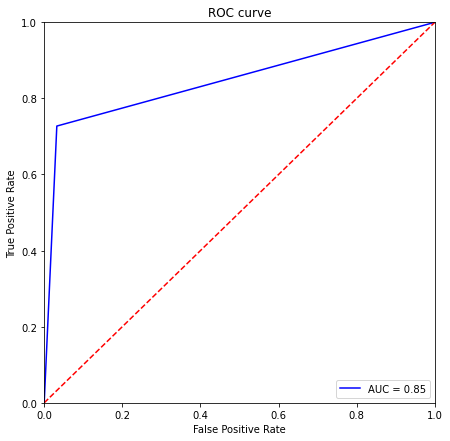

In [48]:
plot_roc_curve(y_val, pred)

Часто хочется понимать, насколько большую роль играет тот или иной признак для предсказания класса объекта. Есть различные способы посчитать его важность. Один из простых способов сделать это для Random Forest выглядит так:
1. Посчитать out-of-bag ошибку предсказания `err_oob` (https://en.wikipedia.org/wiki/Out-of-bag_error)
2. Перемешать значения признака `j` у объектов выборки (у каждого из объектов изменится значение признака `j` на какой-то другой)
3. Посчитать out-of-bag ошибку (`err_oob_j`) еще раз.
4. Оценкой важности признака `j` для одного дерева будет разность `err_oob_j - err_oob`, важность для всего леса считается как среднее значение важности по деревьям.

Реализуйте функцию `feature_importance`, которая принимает на вход Random Forest и возвращает массив, в котором содержится важность для каждого признака.

In [161]:
def feature_importance(rfc, X, labels):    
    oob_errors = np.zeros(rfc.n_estimators)
    
    features_errors = np.zeros(shape=(X.shape[1], rfc.n_estimators))
    
    
    for index, (estimator, oob_indices) in tqdm(enumerate(zip(rfc.estimators, rfc.OOB_indices))):
        X_oob = X.iloc[oob_indices]
        y_oob_true = labels[oob_indices]

        y_oob_predicted = estimator.predict(X_oob)



        oob_error_estimator_i = np.mean(y_oob_predicted == y_oob_true)

        oob_errors[index] = oob_error_estimator_i
        # Считаем `err_oob_j`:
        for feature_index, feature in enumerate(X_oob.columns):
            permutated_features = np.random.permutation(X_oob[feature])
            X_permutated_oob = X_oob.copy()
            X_permutated_oob[feature] = permutated_features
            y_oob_permutated = estimator.predict(X_permutated_oob)
            
            oob_error_feature_j = np.mean(y_oob_permutated == y_oob_true)
            
            features_errors[feature_index, index] = oob_error_estimator_i - oob_error_feature_j
    
    feature_importances = features_errors.mean(1)
    
    return np.around(feature_importances, 2)

    
def most_important_features(importance, names, labels, k=20):
    # Выводит названия k самых важных признаков
    idicies = np.argsort(importance)[::-1][:k]
    return np.array(names)[idicies]

Протестируйте решение на простом синтетическом наборе данных. В результате должна получиться точность `1.0`, наибольшее значение важности должно быть у признака с индексом `4`, признаки с индексами `2` и `3`  должны быть одинаково важны, а остальные признаки - не важны совсем.

In [162]:
def synthetic_dataset(size):
    X = np.array([(np.random.randint(0, 2), np.random.randint(0, 2), i % 6 == 3, 
          i % 6 == 0, i % 3 == 2, np.random.randint(0, 2)) for i in range(size)])
    y = np.array([i % 3 for i in range(size)])
    
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    return X, y

X, y = synthetic_dataset(1000)
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X, y[0])
print("Accuracy:", np.mean(rfc.predict(X) == y[0].values))
print("Importance:", feature_importance(rfc, X, y[0].values))

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy: 1.0


0it [00:00, ?it/s]

Importance: [0.   0.   0.21 0.21 0.4  0.  ]


In [164]:
importance = feature_importance(rfc, X, y[0].values)
most_important_features(importance, X.columns, y)

0it [00:00, ?it/s]

array([4, 3, 2, 5, 1, 0])

In [191]:
feature_importance(random_forest_final, X_tr, y_train[0])

AttributeError: 'RandomForestClassifier' object has no attribute 'estimators'

Проверьте, какие признаки важны для датасета spam? (Используйте файлы x_spam_train и y_spam_train)

_Ваш ответ_

1. Обучите модель на всех данных из x_spam_train и y_spam_train.
2. Сделайте submit своего решения и получите значение f1_score не менее 0.6

In [ ]:
submission = pd.DataFrame(columns = ["Id", "Expected"])
submission["Id"] = test["Id"]
submission["Expected"] = #YOUR CODE
submission.to_csv('submission.csv', index=False)

В качестве альтернативы попробуем библиотечные реализации ансамблей моделей. 

1. [CatBoost](https://catboost.ai/docs/)
2. [XGBoost](https://xgboost.readthedocs.io/en/latest/)
3. [LightGBM](https://lightgbm.readthedocs.io/en/latest/)


Установите необходимые библиотеки. 
Возможно, потребуется установка дополнительных пакетов.

1. Примените модели для нашего датасета.

2. Для стандартного набора параметров у каждой модели нарисуйте `ROC` кривую и выведите `AUC` и `accuracy`.

3. Посчитайте время обучения каждой модели (можно использовать [timeit magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit)).

4. Сравните метрики качества и скорость обучения моделей. Какие выводы можно сделать?



In [187]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import time

In [188]:
def compute_classifier_performance(classifier):
    clf = classifier()
    
    start = time.perf_counter()
    clf.fit(X_tr, y_tr)
    finish = time.perf_counter()
    
    predicted = clf.predict(X_val)
    
    print(f"Fitting time: {finish - start:.2f} seconds")
    print(f"Accuracy score: {accuracy_score(y_true=y_val, y_pred=predicted):.2f}")
    plot_roc_curve(y_pred=predicted, y_true=y_val)

## CatBoost:

Learning rate set to 0.01718
0:	learn: 0.6741452	total: 18.7ms	remaining: 18.7s
1:	learn: 0.6610179	total: 28.2ms	remaining: 14.1s
2:	learn: 0.6452221	total: 37.7ms	remaining: 12.5s
3:	learn: 0.6322854	total: 48ms	remaining: 12s
4:	learn: 0.6178289	total: 58.3ms	remaining: 11.6s
5:	learn: 0.6050492	total: 67ms	remaining: 11.1s
6:	learn: 0.5923868	total: 75.9ms	remaining: 10.8s
7:	learn: 0.5796144	total: 87ms	remaining: 10.8s
8:	learn: 0.5656822	total: 95.6ms	remaining: 10.5s
9:	learn: 0.5532290	total: 104ms	remaining: 10.3s
10:	learn: 0.5412277	total: 114ms	remaining: 10.2s
11:	learn: 0.5315847	total: 122ms	remaining: 10.1s
12:	learn: 0.5207314	total: 132ms	remaining: 9.99s
13:	learn: 0.5114953	total: 141ms	remaining: 9.96s
14:	learn: 0.5018109	total: 150ms	remaining: 9.82s
15:	learn: 0.4915784	total: 158ms	remaining: 9.69s
16:	learn: 0.4810496	total: 168ms	remaining: 9.74s
17:	learn: 0.4727025	total: 178ms	remaining: 9.69s
18:	learn: 0.4653914	total: 190ms	remaining: 9.79s
19:	learn: 

163:	learn: 0.2024618	total: 1.59s	remaining: 8.11s
164:	learn: 0.2022081	total: 1.6s	remaining: 8.12s
165:	learn: 0.2017958	total: 1.61s	remaining: 8.11s
166:	learn: 0.2013526	total: 1.63s	remaining: 8.12s
167:	learn: 0.2010288	total: 1.64s	remaining: 8.11s
168:	learn: 0.2007077	total: 1.65s	remaining: 8.1s
169:	learn: 0.2003044	total: 1.66s	remaining: 8.09s
170:	learn: 0.1999099	total: 1.67s	remaining: 8.08s
171:	learn: 0.1996331	total: 1.68s	remaining: 8.07s
172:	learn: 0.1991944	total: 1.69s	remaining: 8.06s
173:	learn: 0.1990727	total: 1.7s	remaining: 8.05s
174:	learn: 0.1987808	total: 1.71s	remaining: 8.05s
175:	learn: 0.1985216	total: 1.72s	remaining: 8.04s
176:	learn: 0.1982637	total: 1.72s	remaining: 8.02s
177:	learn: 0.1978966	total: 1.74s	remaining: 8.01s
178:	learn: 0.1977439	total: 1.74s	remaining: 8s
179:	learn: 0.1973326	total: 1.75s	remaining: 7.99s
180:	learn: 0.1969212	total: 1.77s	remaining: 7.99s
181:	learn: 0.1966709	total: 1.77s	remaining: 7.97s
182:	learn: 0.1964

333:	learn: 0.1697740	total: 3.19s	remaining: 6.36s
334:	learn: 0.1694957	total: 3.19s	remaining: 6.34s
335:	learn: 0.1692911	total: 3.2s	remaining: 6.33s
336:	learn: 0.1691949	total: 3.21s	remaining: 6.32s
337:	learn: 0.1691665	total: 3.22s	remaining: 6.31s
338:	learn: 0.1691485	total: 3.23s	remaining: 6.3s
339:	learn: 0.1691171	total: 3.24s	remaining: 6.29s
340:	learn: 0.1690400	total: 3.25s	remaining: 6.28s
341:	learn: 0.1688832	total: 3.26s	remaining: 6.26s
342:	learn: 0.1688513	total: 3.27s	remaining: 6.26s
343:	learn: 0.1687130	total: 3.28s	remaining: 6.25s
344:	learn: 0.1686749	total: 3.29s	remaining: 6.24s
345:	learn: 0.1685676	total: 3.3s	remaining: 6.23s
346:	learn: 0.1684728	total: 3.3s	remaining: 6.22s
347:	learn: 0.1683350	total: 3.31s	remaining: 6.21s
348:	learn: 0.1682614	total: 3.32s	remaining: 6.19s
349:	learn: 0.1682252	total: 3.33s	remaining: 6.18s
350:	learn: 0.1679813	total: 3.34s	remaining: 6.17s
351:	learn: 0.1678390	total: 3.35s	remaining: 6.17s
352:	learn: 0.16

496:	learn: 0.1514016	total: 4.79s	remaining: 4.85s
497:	learn: 0.1512333	total: 4.8s	remaining: 4.84s
498:	learn: 0.1511898	total: 4.81s	remaining: 4.83s
499:	learn: 0.1510071	total: 4.82s	remaining: 4.82s
500:	learn: 0.1508524	total: 4.83s	remaining: 4.81s
501:	learn: 0.1508051	total: 4.83s	remaining: 4.79s
502:	learn: 0.1506422	total: 4.84s	remaining: 4.78s
503:	learn: 0.1505492	total: 4.85s	remaining: 4.77s
504:	learn: 0.1504641	total: 4.86s	remaining: 4.76s
505:	learn: 0.1504479	total: 4.87s	remaining: 4.75s
506:	learn: 0.1503510	total: 4.88s	remaining: 4.74s
507:	learn: 0.1501541	total: 4.89s	remaining: 4.73s
508:	learn: 0.1501414	total: 4.9s	remaining: 4.72s
509:	learn: 0.1500470	total: 4.91s	remaining: 4.71s
510:	learn: 0.1500324	total: 4.92s	remaining: 4.71s
511:	learn: 0.1500184	total: 4.93s	remaining: 4.7s
512:	learn: 0.1500020	total: 4.94s	remaining: 4.69s
513:	learn: 0.1497997	total: 4.95s	remaining: 4.68s
514:	learn: 0.1497806	total: 4.96s	remaining: 4.67s
515:	learn: 0.1

667:	learn: 0.1354581	total: 6.39s	remaining: 3.17s
668:	learn: 0.1354438	total: 6.4s	remaining: 3.17s
669:	learn: 0.1353110	total: 6.4s	remaining: 3.15s
670:	learn: 0.1351702	total: 6.42s	remaining: 3.15s
671:	learn: 0.1351104	total: 6.42s	remaining: 3.14s
672:	learn: 0.1351009	total: 6.43s	remaining: 3.13s
673:	learn: 0.1349614	total: 6.45s	remaining: 3.12s
674:	learn: 0.1348359	total: 6.46s	remaining: 3.11s
675:	learn: 0.1348167	total: 6.46s	remaining: 3.1s
676:	learn: 0.1348074	total: 6.47s	remaining: 3.09s
677:	learn: 0.1346822	total: 6.48s	remaining: 3.08s
678:	learn: 0.1346005	total: 6.49s	remaining: 3.07s
679:	learn: 0.1344414	total: 6.5s	remaining: 3.06s
680:	learn: 0.1344321	total: 6.51s	remaining: 3.05s
681:	learn: 0.1343397	total: 6.52s	remaining: 3.04s
682:	learn: 0.1343049	total: 6.53s	remaining: 3.03s
683:	learn: 0.1341954	total: 6.54s	remaining: 3.02s
684:	learn: 0.1341222	total: 6.55s	remaining: 3.01s
685:	learn: 0.1339709	total: 6.56s	remaining: 3s
686:	learn: 0.13381

841:	learn: 0.1204624	total: 7.99s	remaining: 1.5s
842:	learn: 0.1203897	total: 7.99s	remaining: 1.49s
843:	learn: 0.1202750	total: 8s	remaining: 1.48s
844:	learn: 0.1202001	total: 8.01s	remaining: 1.47s
845:	learn: 0.1201681	total: 8.02s	remaining: 1.46s
846:	learn: 0.1201490	total: 8.03s	remaining: 1.45s
847:	learn: 0.1201109	total: 8.04s	remaining: 1.44s
848:	learn: 0.1200145	total: 8.05s	remaining: 1.43s
849:	learn: 0.1200065	total: 8.05s	remaining: 1.42s
850:	learn: 0.1198726	total: 8.06s	remaining: 1.41s
851:	learn: 0.1198023	total: 8.07s	remaining: 1.4s
852:	learn: 0.1197866	total: 8.08s	remaining: 1.39s
853:	learn: 0.1195812	total: 8.09s	remaining: 1.38s
854:	learn: 0.1195714	total: 8.1s	remaining: 1.37s
855:	learn: 0.1193666	total: 8.11s	remaining: 1.36s
856:	learn: 0.1192832	total: 8.12s	remaining: 1.35s
857:	learn: 0.1191906	total: 8.13s	remaining: 1.34s
858:	learn: 0.1191836	total: 8.13s	remaining: 1.33s
859:	learn: 0.1190438	total: 8.14s	remaining: 1.33s
860:	learn: 0.1190

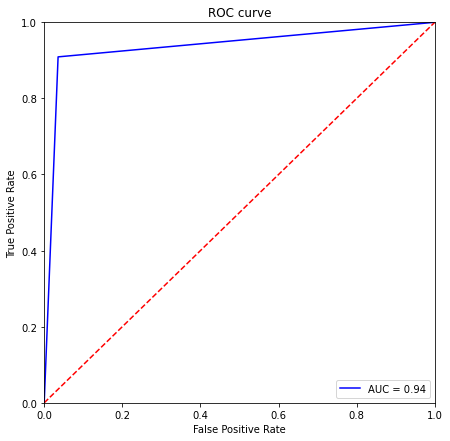

In [182]:
compute_classifier_performance(CatBoostClassifier)

## XGBoost

/home/fvelikonivcev/miniconda3/envs/ml/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:33:01] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting time: 0.88 seconds
Accuracy score: 0.94


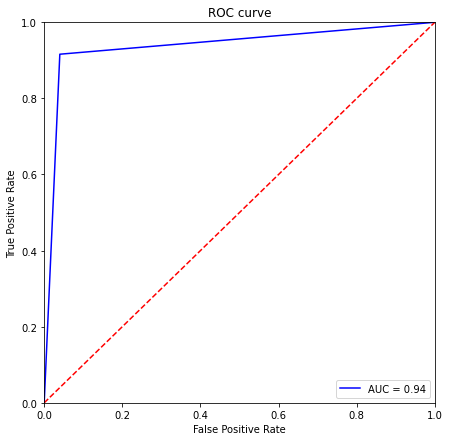

In [185]:
compute_classifier_performance(XGBClassifier)

## LightGBM

Fitting time: 1.63 seconds
Accuracy score: 0.94


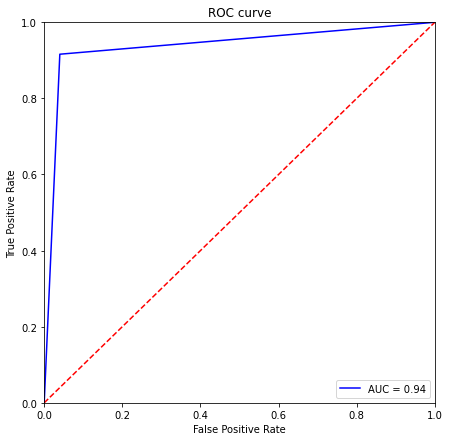

In [189]:
compute_classifier_performance(LGBMClassifier)

__Ответ__: все 3 классификатора показали одинаковую точность и одинаковое значение AUC, быстрее всех отработал XGBoost (1 sec), помедленнее - LightGBM (1.6 sec), медленнее - CatBoost (9.9 sec). Возможно, на другом датасете, с другими данными различия были бы сильнее, однако, сейчас разница в выборе несущественна, потоум что по сравнению с собственной реализацией алгоритма, библиотечные модели отработали мгновенно. Они лучше оптимизированы и с параллеливанием из коробки. Если выбирать, то для этого датасета я бы использовал XGBoost.